In [0]:
#!pip install -U yellowbrick

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 15 02:47:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
%%time
data = pd.read_csv('/content/drive/My Drive/Data/features.csv')
data['Date'] = pd.to_datetime(data['Date'].apply(lambda x: x.split()[0]))

CPU times: user 4.93 s, sys: 437 ms, total: 5.37 s
Wall time: 5.66 s


In [0]:
%%time
for key in data.columns:
    if 'Days' in key:
        data[key] = data[key].apply(round)

CPU times: user 425 ms, sys: 48 ms, total: 473 ms
Wall time: 473 ms


In [0]:
data = data.drop(columns = ['Recnum', 'Cardnum', 'Merchnum', 'Merch description', 'Merch state', 'Merch zip', 'Transtype',
                            'Cardnum_Merchnum', 'Cardnum_Merch zip', 'Cardnum_Merch state'])

In [0]:
data.head()

,Date,Amount,Fraud,Amount_Cardnum_mean_0d,Actual_Amount/Cardnum_mean_0d,Amount_Cardnum_max_0d,Actual_Amount/Cardnum_max_0d,Amount_Cardnum_median_0d,Actual_Amount/Cardnum_median_0d,Amount_Cardnum_sum_0d,Actual_Amount/Cardnum_sum_0d,Cardnum_count_0d,Amount_Cardnum_mean_1d,Actual_Amount/Cardnum_mean_1d,Amount_Cardnum_max_1d,Actual_Amount/Cardnum_max_1d,Amount_Cardnum_median_1d,Actual_Amount/Cardnum_median_1d,Amount_Cardnum_sum_1d,Actual_Amount/Cardnum_sum_1d,Cardnum_count_1d,Amount_Cardnum_mean_3d,Actual_Amount/Cardnum_mean_3d,Amount_Cardnum_max_3d,Actual_Amount/Cardnum_max_3d,Amount_Cardnum_median_3d,Actual_Amount/Cardnum_median_3d,Amount_Cardnum_sum_3d,Actual_Amount/Cardnum_sum_3d,Cardnum_count_3d,Amount_Cardnum_mean_7d,Actual_Amount/Cardnum_mean_7d,Amount_Cardnum_max_7d,Actual_Amount/Cardnum_max_7d,Amount_Cardnum_median_7d,Actual_Amount/Cardnum_median_7d,Amount_Cardnum_sum_7d,Actual_Amount/Cardnum_sum_7d,Cardnum_count_7d,Amount_Cardnum_mean_14d,Actual_Amount/Cardnum_mean_14d,Amount_Cardnum_max_14d,Actual_Amount/Cardnum_max_14d,Amount_Cardnum_median_14d,Actual_Amount/Cardnum_median_14d,Amount_Cardnum_sum_14d,Actual_Amount/Cardnum_sum_14d,Cardnum_count_14d,Amount_Cardnum_mean_30d,Actual_Amount/Cardnum_mean_30d,Amount_Cardnum_max_30d,Actual_Amount/Cardnum_max_30d,Amount_Cardnum_median_30d,Actual_Amount/Cardnum_median_30d,Amount_Cardnum_sum_30d,Actual_Amount/Cardnum_sum_30d,Cardnum_count_30d,Days_since_Cardnum,Amount_Merchnum_mean_0d,Actual_Amount/Merchnum_mean_0d,Amount_Merchnum_max_0d,Actual_Amount/Merchnum_max_0d,Amount_Merchnum_median_0d,Actual_Amount/Merchnum_median_0d,Amount_Merchnum_sum_0d,Actual_Amount/Merchnum_sum_0d,Merchnum_count_0d,Amount_Merchnum_mean_1d,Actual_Amount/Merchnum_mean_1d,Amount_Merchnum_max_1d,Actual_Amount/Merchnum_max_1d,Amount_Merchnum_median_1d,Actual_Amount/Merchnum_median_1d,Amount_Merchnum_sum_1d,Actual_Amount/Merchnum_sum_1d,Merchnum_count_1d,Amount_Merchnum_mean_3d,Actual_Amount/Merchnum_mean_3d,Amount_Merchnum_max_3d,Actual_Amount/Merchnum_max_3d,Amount_Merchnum_median_3d,Actual_Amount/Merchnum_median_3d,Amount_Merchnum_sum_3d,Actual_Amount/Merchnum_sum_3d,Merchnum_count_3d,Amount_Merchnum_mean_7d,Actual_Amount/Merchnum_mean_7d,Amount_Merchnum_max_7d,Actual_Amount/Merchnum_max_7d,Amount_Merchnum_median_7d,Actual_Amount/Merchnum_median_7d,Amount_Merchnum_sum_7d,Actual_Amount/Merchnum_sum_7d,Merchnum_count_7d,Amount_Merchnum_mean_14d,Actual_Amount/Merchnum_mean_14d,Amount_Merchnum_max_14d,Actual_Amount/Merchnum_max_14d,Amount_Merchnum_median_14d,Actual_Amount/Merchnum_median_14d,Amount_Merchnum_sum_14d,Actual_Amount/Merchnum_sum_14d,Merchnum_count_14d,Amount_Merchnum_mean_30d,Actual_Amount/Merchnum_mean_30d,Amount_Merchnum_max_30d,Actual_Amount/Merchnum_max_30d,Amount_Merchnum_median_30d,Actual_Amount/Merchnum_median_30d,Amount_Merchnum_sum_30d,Actual_Amount/Merchnum_sum_30d,Merchnum_count_30d,Days_since_Merchnum,Amount_Cardnum_Merchnum_mean_0d,Actual_Amount/Cardnum_Merchnum_mean_0d,Amount_Cardnum_Merchnum_max_0d,Actual_Amount/Cardnum_Merchnum_max_0d,Amount_Cardnum_Merchnum_median_0d,Actual_Amount/Cardnum_Merchnum_median_0d,Amount_Cardnum_Merchnum_sum_0d,Actual_Amount/Cardnum_Merchnum_sum_0d,Cardnum_Merchnum_count_0d,Amount_Cardnum_Merchnum_mean_1d,Actual_Amount/Cardnum_Merchnum_mean_1d,Amount_Cardnum_Merchnum_max_1d,Actual_Amount/Cardnum_Merchnum_max_1d,Amount_Cardnum_Merchnum_median_1d,Actual_Amount/Cardnum_Merchnum_median_1d,Amount_Cardnum_Merchnum_sum_1d,Actual_Amount/Cardnum_Merchnum_sum_1d,Cardnum_Merchnum_count_1d,Amount_Cardnum_Merchnum_mean_3d,Actual_Amount/Cardnum_Merchnum_mean_3d,Amount_Cardnum_Merchnum_max_3d,Actual_Amount/Cardnum_Merchnum_max_3d,Amount_Cardnum_Merchnum_median_3d,Actual_Amount/Cardnum_Merchnum_median_3d,Amount_Cardnum_Merchnum_sum_3d,Actual_Amount/Cardnum_Merchnum_sum_3d,Cardnum_Merchnum_count_3d,Amount_Cardnum_Merchnum_mean_7d,Actual_Amount/Cardnum_Merchnum_mean_7d,Amount_Cardnum_Merchnum_max_7d,Actual_Amount/Cardnum_Merchnum_max_7d,Amount_Cardnum_Merchnum_median_7d,

In [0]:
data = data[data['Date'] > pd.to_datetime('2010-01-14')]
train = data[data['Date'] <= pd.to_datetime('2020-10-31')].copy()

In [0]:
X = train.drop(columns=['Fraud', 'Date'])
y = train['Fraud']

In [0]:
rfe = RFE(xgb.XGBRFClassifier(tree_method = 'gpu_hist'), verbose = 0, n_features_to_select = 30)

In [0]:
%%time
rfe.fit(X, y)

CPU times: user 3min 11s, sys: 1min 21s, total: 4min 32s
Wall time: 4min 32s


RFE(estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1,
                              colsample_bynode=0.8, colsample_bytree=1, gamma=0,
                              learning_rate=1, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=1, nthread=None,
                              objective='binary:logistic', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=None, subsample=0.8,
                              tree_method='gpu_hist', verbosity=1),
    n_features_to_select=30, step=1, verbose=0)

In [0]:
sel = [X.columns[i] for i in rfe.get_support(indices=True)]

In [0]:
len(sel)

30

In [0]:
sel

['Amount_Cardnum_sum_0d',
 'Cardnum_count_0d',
 'Amount_Cardnum_sum_1d',
 'Amount_Merchnum_mean_0d',
 'Amount_Merchnum_max_0d',
 'Amount_Merchnum_sum_0d',
 'Amount_Merchnum_max_1d',
 'Amount_Cardnum_Merchnum_max_0d',
 'Amount_Cardnum_Merch zip_sum_0d',
 'Amount_Cardnum_Merch zip_max_3d',
 'Amount_Cardnum_Merch zip_sum_3d',
 'Cardnum_Merch zip_count_3d',
 'Amount_Cardnum_Merch zip_sum_7d',
 'Cardnum_Merch zip_count_7d',
 'Amount_Cardnum_Merch zip_max_14d',
 'Amount_Cardnum_Merch zip_sum_14d',
 'Cardnum_Merch zip_count_14d',
 'Amount_Cardnum_Merch zip_max_30d',
 'Amount_Cardnum_Merch zip_sum_30d',
 'Amount_Cardnum_Merch state_max_1d',
 'Amount_Cardnum_Merch state_max_3d',
 'Amount_Cardnum_Merch state_sum_3d',
 'Amount_Cardnum_Merch state_max_7d',
 'count_Cardnum_0d/mean_mean_Cardnum_14d',
 'count_Cardnum_0d/mean_mean_Cardnum_30d',
 'count_Cardnum_0d/mean_count_Cardnum_30d',
 'count_Cardnum_1d/mean_mean_Cardnum_30d',
 'count_Cardnum_1d/mean_count_Cardnum_30d',
 'count_Merchnum_0d/mean_cou

In [0]:
X = X[sel]

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


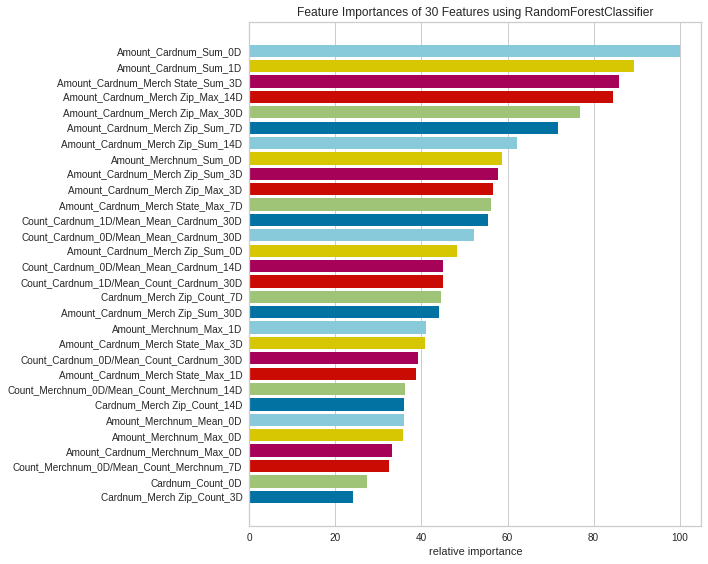

In [0]:
plt.figure(figsize=(10,8))
ax = plt.gca()
labels = list(map(lambda s: s.title(), X.columns))
viz = FeatureImportances(RandomForestClassifier(n_jobs = -1), labels=labels, relative=True)
viz.fit(X, y)
viz.show(ax=ax)